## Imports

In [37]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

## Parameters

In [38]:
INPUT_FILE = Path.cwd() / 'weather_data.csv'
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_EPOCHS = 30

In [39]:
print(pd.read_csv(INPUT_FILE).head())

   Humidity  Visibility (km)  Temperature (C)
0      0.89            0.983         0.523486
1      0.86            0.983         0.521084
2      0.89            0.929         0.553144
3      0.83            0.983         0.501947
4      0.83            0.983         0.517356


In [40]:
def get_data(
    filename: str = INPUT_FILE,
    test_size: float = 0.25,
    random_state: int = 42,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Get data from the input file, split it into train and test sets.

    Args:
        filename: Path to the input file.
        test_size: Fraction of the data to use for testing.
        random_state: Random seed for shuffling the data.

    Returns:
        tuple: (x_train, x_test, y_train, y_test)
    """
    df = pd.read_csv(filename)

    # split data
    x_train, x_test, y_train, y_test = train_test_split(
        df[['Humidity', 'Visibility (km)']],
        df[['Temperature (C)']],
        test_size=test_size,
        random_state=random_state,
    )

    return (
        np.array(x_train),
        np.array(x_test),
        np.array(y_train),
        np.array(y_test),
    )

In [41]:
def data_iter(
    x_samples: np.ndarray,
    y_samples: np.ndarray,
    batch_size: int = BATCH_SIZE,
):
    """
    Iterate over the data and corresponding output in batches.

    Args:
        x_samples: Data to iterate over.
        y_samples: Labels to iterate over.
        batch_size: Size of the batches.

    Yields:
        tuple: (batch_data, batch_labels)
    """
    num_examples = len(x_samples)
    indices = list(range(num_examples))

    # examples are read at random, in no particular order
    random.shuffle(indices)
    for idx in range(0, num_examples, batch_size):
        batch_x = x_samples[indices[idx:idx + batch_size]]
        batch_y = y_samples[indices[idx:idx + batch_size]]
        yield batch_x, batch_y

In [42]:
def create_model_parameter(
    mu: float,
    sigma: float,
    rows: int,
    columns: int,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Create model parameters from the input data.

    Args:
        mu: Mean of the data.
        sigma: Standard deviation of the data.
        rows: Number of rows in the data.
        columns: Number of columns in the data.

    Returns:
        tuple: Normal weights and biases.
    """
    weights = np.random.normal(mu, sigma, size=(rows, columns))
    biases = np.zeros(1)
    return weights, biases

In [43]:
def model(
    input_data: np.ndarray,
    weights: np.ndarray,
    biases: np.ndarray,
) -> np.ndarray:
    """
    Model function.

    Args:
        input_data: Input data.
        weights: Weights.
        biases: Biases.

    Returns:
        np.ndarray: Output of the model.
    """
    return np.dot(input_data, weights) + biases.T

In [44]:
def squared_loss(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """Calculate squared loss.

    Args:
        y_pred: Predicted output.
        y_true: True output.

    Returns:
        float: Squared loss.
    """
    return np.mean((y_pred - y_true) ** 2) / 2

In [45]:
def gradient(
    y_pred: np.ndarray,
    y_actual: np.ndarray,
    input_data: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculate the gradient of the loss function.

    Args:
        y_pred: Predicted output.
        y_actual: True output.
        input_data: Input data.

    Returns:
        tuple: Gradients.
    """
    weights_grad = np.sum((y_pred - y_actual) * input_data)
    biases_grad = np.sum((y_pred - y_actual))
    return weights_grad, biases_grad

In [46]:
def sgd(
    model_params: tuple[np.ndarray, np.ndarray],
    grads: tuple[np.ndarray, np.ndarray],
    learning_rate: float = LEARNING_RATE,
    batch_size: int = BATCH_SIZE,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Perform stochastic gradient descent.

    Args:
        model_params: Model parameters.
        grads: Gradients.
        learning_rate: Learning_rate.
        batch_size: Batch size.

    Returns:
        tuple: Updated model parameters.
    """
    weights, biases = model_params
    weights_grad, biases_grad = grads

    weights_update = learning_rate * (weights_grad / batch_size)
    biases_update = learning_rate * (biases_grad / batch_size)

    weights -= weights_update
    biases -= biases_update
    return weights, biases

In [47]:
def train(
    x_train: np.ndarray,
    y_train: np.ndarray,
    num_epochs: int = NUM_EPOCHS,
    learning_rate: float = LEARNING_RATE,
    batch_size: int = BATCH_SIZE,
) -> tuple[np.ndarray, np.ndarray, list]:
    """
    Train the model.

    Args:
        x_train: Training data.
        y_train: Training labels.
        num_epochs: Number of epochs.
        learning_rate: Learning rate.
        batch_size: Batch size.

    Returns:
        tuple: Model parameters.
    """
    weights, biases = create_model_parameter(
        mu=0,
        sigma=0.1,
        rows=x_train.shape[1],
        columns=1,
    )

    losses = []
    for epoch in range(num_epochs):
        for batch_x, batch_y in data_iter(x_train, y_train, batch_size):
            # calculate loss and gradients
            y_pred = model(batch_x, weights, biases)
            grads = gradient(y_pred, batch_y, batch_x)

            # update model parameters
            weights, biases = sgd(
                model_params=(weights, biases),
                grads=grads,
                learning_rate=learning_rate,
                batch_size=batch_size,
            )
        train_l = squared_loss(model(x_train, weights, biases), y_train)
        losses.append(train_l)
        print('Epoch {0}: Loss = {1}'.format(epoch + 1, train_l))

    return weights, biases, losses

In [48]:
def test(
    x_test: np.ndarray,
    y_test: np.ndarray,
    model_params: tuple[np.ndarray, np.ndarray],
) -> float:
    """
    Test the model.

    Args:
        x_test: Test data.
        y_test: Test labels.
        model_params: Model parameters.

    Returns:
        float: Test loss.
    """
    weights, biases = model_params
    return squared_loss(model(x_test, weights, biases), y_test)

In [49]:
X_train, X_test, y_train, y_test = get_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72321, 2) (24108, 2) (72321, 1) (24108, 1)


Epoch 1: Loss = 0.013474579109272643
Epoch 2: Loss = 0.012435321703912112
Epoch 3: Loss = 0.01182269712928141
Epoch 4: Loss = 0.011458635237382114
Epoch 5: Loss = 0.011242993017007725
Epoch 6: Loss = 0.011113880075645887
Epoch 7: Loss = 0.011042760733492031
Epoch 8: Loss = 0.010993838130747164
Epoch 9: Loss = 0.010968115169768063
Epoch 10: Loss = 0.010955146335638245
Epoch 11: Loss = 0.010944138897326934
Epoch 12: Loss = 0.010937762378639854
Epoch 13: Loss = 0.010934500163469363
Epoch 14: Loss = 0.010932573649382408
Epoch 15: Loss = 0.010931617219469333
Epoch 16: Loss = 0.01093077494584062
Epoch 17: Loss = 0.01093171339184456
Epoch 18: Loss = 0.010930668424015152
Epoch 19: Loss = 0.010930311953360177
Epoch 20: Loss = 0.010931682273407912
Epoch 21: Loss = 0.010932494137910313
Epoch 22: Loss = 0.010931471183061665
Epoch 23: Loss = 0.010935500096246432
Epoch 24: Loss = 0.010933058688459918
Epoch 25: Loss = 0.010930905161353421
Epoch 26: Loss = 0.010936601350903399
Epoch 27: Loss = 0.01093

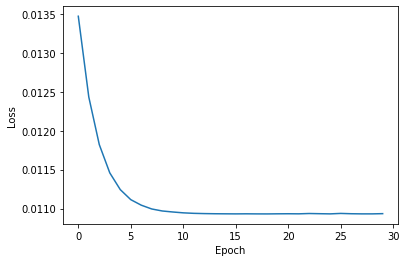

In [50]:
weights, biases, losses = train(
    x_train=X_train,
    y_train=y_train,
)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss.png')
plt.show()

In [51]:
test_loss = test(
    x_test=X_test,
    y_test=y_test,
    model_params=(weights, biases),
)
print('Test loss: {0}'.format(test_loss))

Test loss: 0.011060220262912743


Epoch 1: Loss = 0.016823216768495568
Epoch 2: Loss = 0.016546415213427805
Epoch 3: Loss = 0.016514610656722127
Epoch 4: Loss = 0.016593911509669514
Epoch 5: Loss = 0.01651008325474157
Epoch 6: Loss = 0.01651013020887422
Epoch 7: Loss = 0.01651231199124807
Epoch 8: Loss = 0.0165110560657337
Epoch 9: Loss = 0.016523772637588273
Epoch 10: Loss = 0.016525135987824933
Epoch 11: Loss = 0.016510932986919215
Epoch 12: Loss = 0.01651329319548043
Epoch 13: Loss = 0.01652002187635552
Epoch 14: Loss = 0.016509286688214057
Epoch 15: Loss = 0.016518449523104668
Epoch 16: Loss = 0.0165089723613275
Epoch 17: Loss = 0.016523600974948205
Epoch 18: Loss = 0.0165156741433108
Epoch 19: Loss = 0.016515407634014382
Epoch 20: Loss = 0.016510767633130214
Epoch 21: Loss = 0.01651016257347618
Epoch 22: Loss = 0.016510588808098917
Epoch 23: Loss = 0.016517625441790033
Epoch 24: Loss = 0.016521801422314453
Epoch 25: Loss = 0.0165627119746613
Epoch 26: Loss = 0.016509190124981372
Epoch 27: Loss = 0.0165095082759575

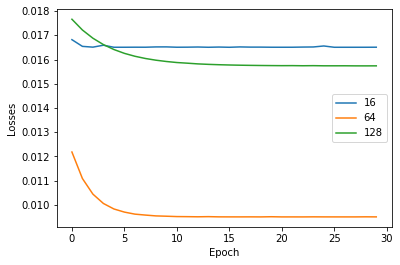

In [52]:
plt.clf()
plt.xlabel('Epoch')
plt.ylabel('Losses')
batches = [16, 64, 128]
for batch_size in batches:
    weights, biases, losses = train(
        x_train=X_train,
        y_train=y_train,
        batch_size=batch_size,
    )

    test_loss = test(
        x_test=X_test,
        y_test=y_test,
        model_params=(weights, biases),
    )
    print('Test loss: {0}'.format(test_loss))

    plt.plot(losses)
    plt.legend(batches)
plt.savefig('loss_batches.png')
plt.show()

# Adjusting the batch sizes changes how quickly the model converges. In a small
# batch size, the algorithm may converge quickly. In a large batch size, the
# algorithm may take a long time to converge.